In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [2]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    timings = []
    for d in data["datapoints"]:
        s = d["setting"]
        t = list(map(lambda x: (x["computationTime"], x['mpiTime']),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        for time in t:
            timings.append(time)
    return timings

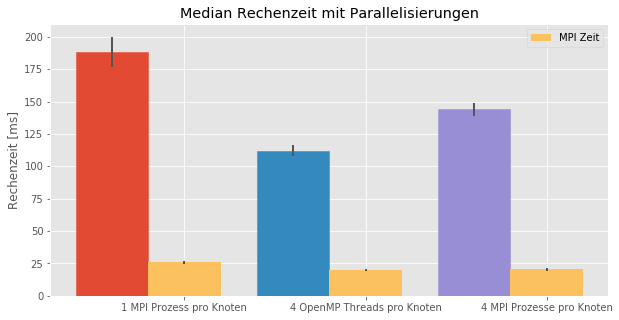

In [3]:
normalT = load_json("./data_parallel_normal.json")
ompT = load_json("./data_parallel_4_OpenMP.json")
mpiT = load_json("./data_parallel_4_MPI.json")

# timings in ms
def stat(data):
    a, b = zip(*data)
    a, b = np.asarray(a) / 1e3, np.asarray(b) / 1e3
    # 99% CI
    z = 2.58
    
    m = np.mean(a)
    ci = z * np.std(a) / np.sqrt(len(a))
    m2 = np.mean(b)
    ci2 = z * np.std(b) / np.sqrt(len(b))
    return m, ci, m2, ci2

normal, normalErr, normalMPI, normalMPIerr = stat(normalT)
omp, ompErr, ompMPI, ompMPIerr = stat(ompT)
mpi, mpiErr, mpiMPI, mpiMPIerr = stat(mpiT)


x_ticks = ["1 MPI Prozess pro Knoten", "4 OpenMP Threads pro Knoten", "4 MPI Prozesse pro Knoten"]
x = np.arange(len(x_ticks))
y = (normal, omp, mpi)
yerr = (normalErr, ompErr, mpiErr)


fig, ax = plt.subplots(figsize=(10,5))
total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

barlist = ax.bar(alteration[0] + x, y, align='center', width=ind_width)

barlist[0].set_color('#E24A33')
barlist[1].set_color('#348ABD')
barlist[2].set_color('#988ED5')

yMPI = (normalMPI, ompMPI, mpiMPI)
yMPIErr = (normalMPIerr, ompMPIerr, mpiMPIerr)
ax.bar(alteration[1] + x, yMPI, align='center', color='#FBC15E', width=ind_width, label='MPI Zeit')


ax.errorbar(alteration[0] + x, y, yerr=yerr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.errorbar(alteration[1] + x, yMPI, yerr=yMPIErr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.set_ylabel('Rechenzeit [ms]')
ax.set_title('Median Rechenzeit mit Parallelisierungen')

ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
ax.legend()
#plt.yscale('log')
#save_fig(fig, 'parallelism')

plt.show()
